In [1]:

%cd '../..'
%pwd

/home/arslan/PycharmProjects/pr


/home/arslan/.cache/pypoetry/virtualenvs/pr-1TEpFMsl-py3.11/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/arslan/PycharmProjects/pr'

In [2]:
import random
from typing import Callable

import albumentations as album
import torch.nn as nn
import torch.utils.data as data
from torchinfo import summary
from tqdm import tqdm

from azulvision.square_classifier.config import *
from azulvision.square_classifier.dataset import SCDataset
from azulvision.square_classifier.model import resnet18
from azulvision.utils import visualize

In [3]:
print("All dataset classes and their corresponding folders:")
print("Class Names:", CLASS_NAMES)
print("Class Folders:", CLASS_DIRS)

All dataset classes and their corresponding folders:
Class Names: ['black_bg', 'blue_bg', 'red_bg', 'white_bg', 'yellow_bg', 'black', 'blue', 'red', 'white', 'yellow']
Class Folders: {'black_bg': '_black', 'blue_bg': '_blue', 'red_bg': '_red', 'white_bg': '_white', 'yellow_bg': '_yellow', 'black': 'BLACK', 'blue': 'BLUE', 'red': 'RED', 'white': 'WHITE', 'yellow': 'YELLOW'}


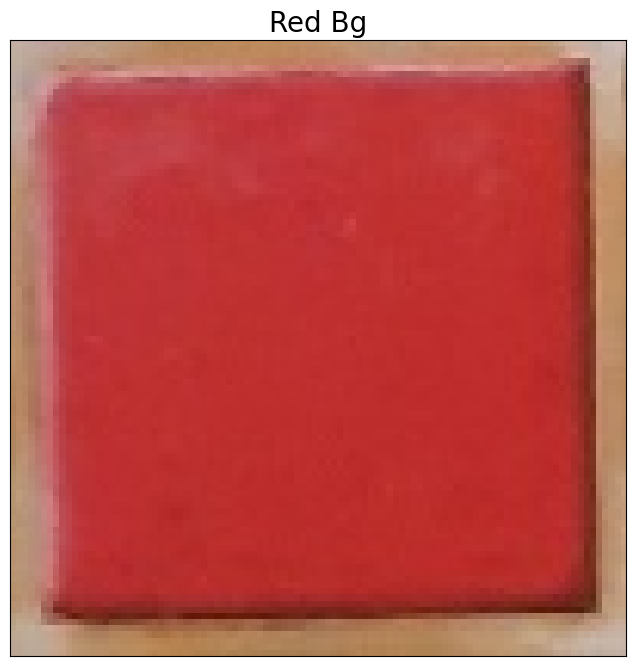

In [4]:
dataset = SCDataset(SC_DATA_DIR, CLASS_DIRS)
random_idx = random.randint(0, len(dataset) - 1)
img, cls = dataset[random_idx]

visualize(
    **{
        dataset.decode_cls(cls)[0]: img
    }
)

In [5]:
training_augmentation = album.Compose([
    album.RandomBrightnessContrast(always_apply=True),
    album.OneOf([
        album.HorizontalFlip(p=1),
        album.VerticalFlip(p=1),
        album.RandomRotate90(p=1)
    ],
        p=0.75
    )
])


def get_preprocessing(preprocessing_fn: Callable[[np.ndarray], np.ndarray] | None = None) -> album.Compose:
    def to_tensor(x: np.ndarray, **kwargs):
        _ = kwargs
        x = x.transpose(2, 0, 1).astype('float32')
        return x

    transform = []
    if preprocessing_fn:
        transform.append(album.Lambda(image=preprocessing_fn))
    transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(transform)

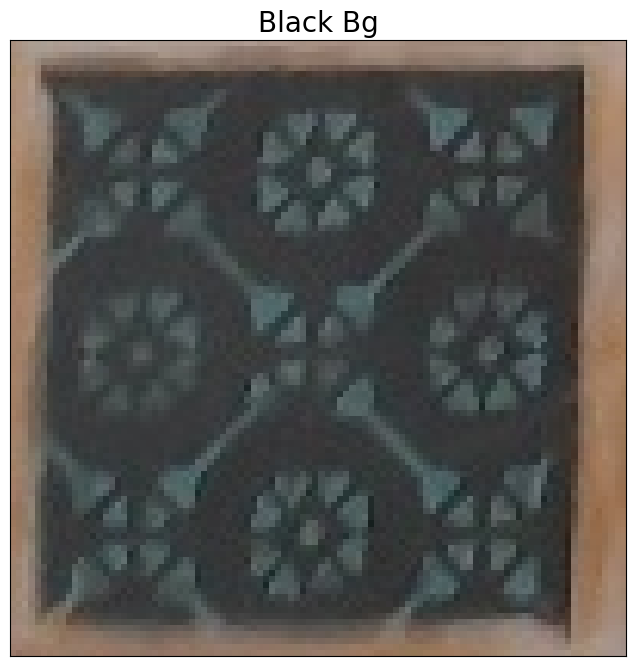

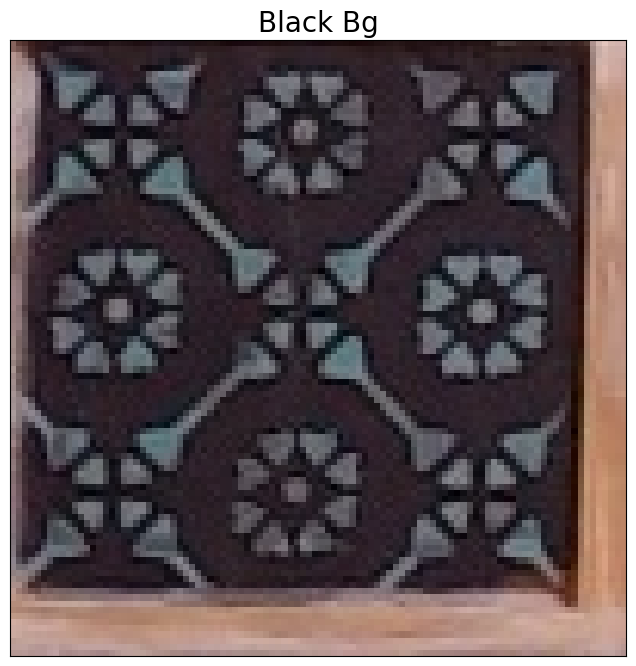

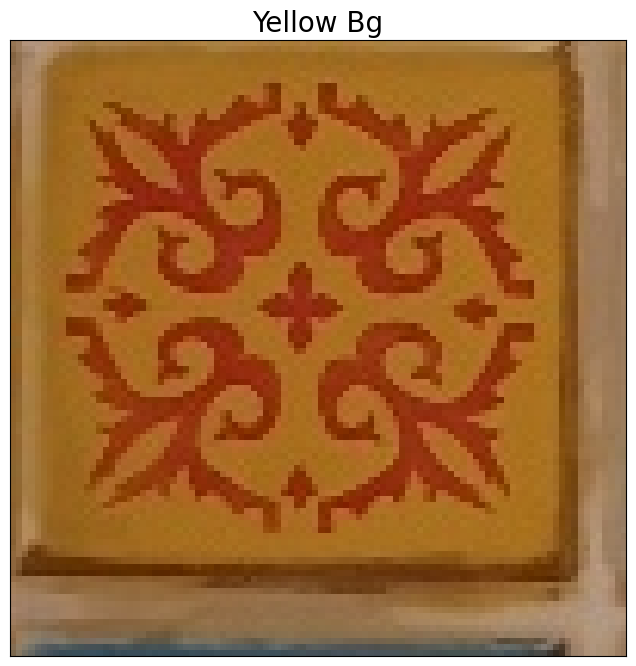

In [6]:
augmented_dataset = SCDataset(
    SC_DATA_DIR,
    CLASS_DIRS,
    augmentation=training_augmentation
)

for i in range(3):
    random_idx = random.randint(0, len(augmented_dataset) - 1)
    img, cls = augmented_dataset[random_idx]
    visualize(
        **{
            dataset.decode_cls(cls)[0]: img
        }
    )

In [7]:
dataset = SCDataset(
    SC_DATA_DIR,
    CLASS_DIRS,
    augmentation=training_augmentation,
    preprocessing=get_preprocessing()
)

train_dataset, valid_dataset, test_dataset = data.random_split(dataset, [0.7, 0.2, 0.1],
                                                               torch.Generator().manual_seed(42))

train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                               pin_memory=PIN_MEMORY)
valid_loader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                               pin_memory=PIN_MEMORY)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=PIN_MEMORY)

In [8]:
TRAINING = True

print(f"Using device: {DEVICE}")

model = resnet18(
    in_channels=3,
    n_classes=len(CLASS_NAMES)
)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=INIT_LR)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=5,
    verbose=True,
)

if MODEL_WEIGHTS.exists():
    model = torch.load(MODEL_WEIGHTS)

summary(model, (BATCH_SIZE, 3, 100, 100))

Using device: cuda


Layer (type:depth-idx)                                       Output Shape              Param #
ResNet                                                       [8, 10]                   --
├─ResNetEncoder: 1-1                                         [8, 512, 4, 4]            --
│    └─Sequential: 2-1                                       [8, 64, 25, 25]           --
│    │    └─Conv2d: 3-1                                      [8, 64, 50, 50]           9,408
│    │    └─BatchNorm2d: 3-2                                 [8, 64, 50, 50]           128
│    │    └─ReLU: 3-3                                        [8, 64, 50, 50]           --
│    │    └─MaxPool2d: 3-4                                   [8, 64, 25, 25]           --
│    └─ModuleList: 2-2                                       --                        --
│    │    └─ResNetLayer: 3-5                                 [8, 64, 25, 25]           147,968
│    │    └─ResNetLayer: 3-6                                 [8, 128, 13, 13]         

In [9]:
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print("Training")
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        img, cls = data
        img = img.to(device)
        cls = cls.to(device).squeeze()

        optimizer.zero_grad()

        out = model(img)

        loss = criterion(out, cls)
        train_running_loss += loss.item()

        _, preds = torch.max(out.data, 1)
        train_running_correct += (preds == cls).sum().item()

        loss.backward()

        optimizer.step()

    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))

    return epoch_loss, epoch_acc


def validate(model, validloader, criterion, device):
    model.eval()
    print("Validation")
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(validloader), total=len(validloader)):
            counter += 1

            img, cls = data
            img = img.to(device)
            cls = cls.to(device).squeeze()

            out = model(img)

            loss = criterion(out, cls)
            valid_running_loss += loss.item()

            _, preds = torch.max(out.data, 1)
            valid_running_correct += (preds == cls).sum().item()

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(validloader.dataset))
    return epoch_loss, epoch_acc

In [10]:
%%time

if TRAINING:
    counter = 0
    best_valid_acc = 0
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    for epoch in range(NUM_EPOCHS):
        print(f"EPOCH {epoch + 1}")

        train_epoch_loss, train_epoch_acc = train(
            model,
            train_loader,
            optimizer,
            loss,
            DEVICE
        )
        valid_epoch_loss, valid_epoch_acc = validate(
            model,
            valid_loader,
            loss,
            DEVICE
        )

        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_loss.append(valid_epoch_loss)
        valid_acc.append(valid_epoch_acc)

        if valid_epoch_acc > best_valid_acc:
            best_valid_acc = valid_epoch_acc
            torch.save(model, MODEL_WEIGHTS)
            print("Model saved")
            counter = 0
        else:
            counter += 1
            if counter >= 10:
                print("Early stop")
                break

        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-' * 50)


EPOCH 1
Training


100%|██████████| 1735/1735 [00:21<00:00, 79.63it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 183.19it/s]

Model saved
Training loss: 0.320, training acc: 89.278
Validation loss: 0.087, validation acc: 97.629
--------------------------------------------------
EPOCH 2
Training



100%|██████████| 1735/1735 [00:21<00:00, 82.33it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 179.21it/s]


Model saved
Training loss: 0.117, training acc: 96.239
Validation loss: 0.056, validation acc: 97.781
--------------------------------------------------
EPOCH 3
Training


100%|██████████| 1735/1735 [00:21<00:00, 81.88it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 199.70it/s]


Model saved
Training loss: 0.079, training acc: 97.572
Validation loss: 0.044, validation acc: 98.663
--------------------------------------------------
EPOCH 4
Training


100%|██████████| 1735/1735 [00:21<00:00, 81.69it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 197.43it/s]


Model saved
Training loss: 0.061, training acc: 98.220
Validation loss: 0.038, validation acc: 98.840
--------------------------------------------------
EPOCH 5
Training


100%|██████████| 1735/1735 [00:21<00:00, 79.52it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 193.01it/s]

Training loss: 0.049, training acc: 98.552
Validation loss: 0.036, validation acc: 98.764
--------------------------------------------------
EPOCH 6
Training



100%|██████████| 1735/1735 [00:22<00:00, 78.45it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 190.09it/s]

Training loss: 0.045, training acc: 98.602
Validation loss: 0.063, validation acc: 97.705
--------------------------------------------------
EPOCH 7
Training



100%|██████████| 1735/1735 [00:21<00:00, 80.75it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 182.37it/s]


Model saved
Training loss: 0.036, training acc: 99.027
Validation loss: 0.030, validation acc: 99.369
--------------------------------------------------
EPOCH 8
Training


100%|██████████| 1735/1735 [00:21<00:00, 81.73it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 189.09it/s]

Training loss: 0.035, training acc: 98.934
Validation loss: 0.034, validation acc: 98.966
--------------------------------------------------
EPOCH 9
Training



100%|██████████| 1735/1735 [00:21<00:00, 80.98it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 195.27it/s]

Training loss: 0.028, training acc: 99.207
Validation loss: 0.029, validation acc: 99.067
--------------------------------------------------
EPOCH 10
Training



100%|██████████| 1735/1735 [00:21<00:00, 80.37it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 197.54it/s]

Training loss: 0.025, training acc: 99.265
Validation loss: 0.027, validation acc: 99.319
--------------------------------------------------
EPOCH 11
Training



100%|██████████| 1735/1735 [00:21<00:00, 81.22it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 184.58it/s]

Training loss: 0.024, training acc: 99.315
Validation loss: 0.026, validation acc: 99.243
--------------------------------------------------
EPOCH 12
Training



100%|██████████| 1735/1735 [00:21<00:00, 81.66it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 194.44it/s]


Model saved
Training loss: 0.021, training acc: 99.373
Validation loss: 0.017, validation acc: 99.470
--------------------------------------------------
EPOCH 13
Training


100%|██████████| 1735/1735 [00:21<00:00, 80.13it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 188.71it/s]

Training loss: 0.018, training acc: 99.496
Validation loss: 0.024, validation acc: 99.395
--------------------------------------------------
EPOCH 14
Training



100%|██████████| 1735/1735 [00:21<00:00, 81.19it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 185.38it/s]


Model saved
Training loss: 0.020, training acc: 99.373
Validation loss: 0.019, validation acc: 99.496
--------------------------------------------------
EPOCH 15
Training


100%|██████████| 1735/1735 [00:22<00:00, 76.56it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 193.52it/s]

Training loss: 0.016, training acc: 99.539
Validation loss: 0.026, validation acc: 99.445
--------------------------------------------------
EPOCH 16
Training



100%|██████████| 1735/1735 [00:21<00:00, 80.74it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 192.70it/s]

Training loss: 0.014, training acc: 99.633
Validation loss: 0.026, validation acc: 99.395
--------------------------------------------------
EPOCH 17
Training



100%|██████████| 1735/1735 [00:21<00:00, 82.13it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 196.64it/s]


Model saved
Training loss: 0.018, training acc: 99.510
Validation loss: 0.018, validation acc: 99.546
--------------------------------------------------
EPOCH 18
Training


100%|██████████| 1735/1735 [00:21<00:00, 81.61it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 190.45it/s]

Training loss: 0.019, training acc: 99.481
Validation loss: 0.017, validation acc: 99.445
--------------------------------------------------
EPOCH 19
Training



100%|██████████| 1735/1735 [00:21<00:00, 81.33it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 173.83it/s]

Training loss: 0.015, training acc: 99.596
Validation loss: 0.024, validation acc: 99.470
--------------------------------------------------
EPOCH 20
Training



100%|██████████| 1735/1735 [00:22<00:00, 78.64it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 184.96it/s]

Training loss: 0.012, training acc: 99.690
Validation loss: 0.018, validation acc: 99.546
--------------------------------------------------
EPOCH 21
Training



100%|██████████| 1735/1735 [00:21<00:00, 80.46it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 186.22it/s]

Training loss: 0.012, training acc: 99.640
Validation loss: 0.027, validation acc: 99.344
--------------------------------------------------
EPOCH 22
Training



100%|██████████| 1735/1735 [00:21<00:00, 80.65it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 183.66it/s]

Training loss: 0.013, training acc: 99.669
Validation loss: 0.018, validation acc: 99.546
--------------------------------------------------
EPOCH 23
Training



100%|██████████| 1735/1735 [00:21<00:00, 79.39it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 197.81it/s]

Training loss: 0.013, training acc: 99.611
Validation loss: 0.022, validation acc: 99.344
--------------------------------------------------
EPOCH 24
Training



100%|██████████| 1735/1735 [00:21<00:00, 80.03it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 183.20it/s]

Training loss: 0.011, training acc: 99.697
Validation loss: 0.029, validation acc: 99.319
--------------------------------------------------
EPOCH 25
Training



100%|██████████| 1735/1735 [00:21<00:00, 79.25it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 190.79it/s]

Training loss: 0.010, training acc: 99.712
Validation loss: 0.036, validation acc: 98.890
--------------------------------------------------
EPOCH 26
Training



100%|██████████| 1735/1735 [00:21<00:00, 79.33it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 191.18it/s]

Training loss: 0.009, training acc: 99.762
Validation loss: 0.018, validation acc: 99.546
--------------------------------------------------
EPOCH 27
Training



100%|██████████| 1735/1735 [00:21<00:00, 80.20it/s]

Validation



100%|██████████| 496/496 [00:02<00:00, 192.26it/s]

Early stop
CPU times: user 8min 5s, sys: 2min 46s, total: 10min 51s
Wall time: 11min 5s


In [11]:
if MODEL_WEIGHTS.exists():
    print("Loading best model from this run.")
    model = torch.load(MODEL_WEIGHTS)

Loading best model from this run.
